In [1]:
import transcriptic 
from transcriptic import commands, Container
from transcriptic.config import Connection
from transcriptic.jupyter import objects
import json
from pysd2cat.data import tx_fcs
from pysd2cat.data import pipeline
#from pysd2cat.analysis import biofab_live_dead_analysis as blda
#from pysd2cat.data import biofab_live_dead as bld


from os.path import expanduser
import requests
import os
import zipfile
import shutil
import fnmatch
import glob
import pandas as pd
import ast

import pysd2cat.analysis.container_data_conversion as cdc
from pysd2cat.analysis.plate_layout import solve1, get_model_pd, get_sample_types


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Connection.from_file("~/.transcriptic")

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pysmt/walkers/generic.py:43: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  i

In [12]:
def convert_ftypes(factors):
    for factor_id, factor in factors.items():
        if factor_id == "strain" or factor_id == "replicate":
            factor['ftype'] = 'aliquot'
        elif factor_id == "timepoint":
            factor['ftype'] = 'sample'
        
    return factors

def strip_aliquot_properties(container):
    for aliquot_id in container['aliquots']:
        container['aliquots'][aliquot_id] = {}
    return container

In [9]:
ex_num = 0
experiment_files = [
    "gen_experiment_request_growth_curve.json",
    "gen_experiment_request_growth_curve_corrected.json", # Need to fix container ids
    ""
]
this_dir = os.getcwd()
experiment_file_dir = os.path.realpath(os.path.join(this_dir, '../../../tests/data/'))

request = json.load(open(os.path.join(experiment_file_dir, experiment_files[ex_num])))

c2ds  = { container.id : strip_aliquot_properties(cdc.container_to_dict(container))
          for container in [objects.Container(x) for x in request['defaults']['constants']['container_search_string']]  }

inputs = {
    "samples" : None,
    "factors" : convert_ftypes(request['condition_space']['factors']),
    "requirements" : request['defaults']['conditions'],
    "containers" : c2ds
}

In [11]:
model, variables = solve1(inputs)
df = get_model_pd(model, variables, inputs['factors'])

Generating Constraints ...
Solving ...


In [17]:
df


,aliquot,container,replicate,strain,sample,measurement_type,timepoint,recovery_media,temperature
0,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x0_a1_ct1dqvp6ntpb7e3,PLATE_READER,1.0,sc_media_200nm_be,30.0
1,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x1_a1_ct1dqvp6ntpb7e3,PLATE_READER,3.0,sc_media_200nm_be,30.0
2,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x2_a1_ct1dqvp6ntpb7e3,PLATE_READER,6.0,sc_media_200nm_be,30.0
3,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x3_a1_ct1dqvp6ntpb7e3,PLATE_READER,9.0,sc_media_200nm_be,30.0
4,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x4_a1_ct1dqvp6ntpb7e3,PLATE_READER,12.0,sc_media_200nm_be,30.0
...,...,...,...,...,...,...,...,...,...
1723,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x4_h9_ct1dqvp6p255zar,PLATE_READER,12.0,sc_media,30.0
1724,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x5_h9_ct1dqvp6p255zar,PLATE_READER,15.0,sc_media,30.0
1725,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x6_h9_ct1dqvp6p255zar,PLATE_READER,18.0,sc_media,30.0
1726,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x7_h9_ct1dqvp6p255zar,PLATE_READER,21.0,sc_media,30.0


In [25]:
#df[['aliquot', 'container', 'measurement_type', 'timepoint']].sort_values(by=['container', 'aliquot', 'timepoint'], ascending=True).drop_duplicates()
df[['aliquot', 'container', 'strain']].sort_values(by=['container', 'aliquot', 'strain'], ascending=True).drop_duplicates().strain.value_counts()
#print(df[['aliquot', 'container', 'strain']].sort_values(by=['container', 'aliquot', 'strain'], ascending=True).drop_duplicates().to_string())
df[['aliquot', 'container', 'strain']].sort_values(by=['container', 'aliquot', 'strain'], ascending=True).drop_duplicates()
#df.dtypes
#df

,aliquot,container,strain
0,a1,ct1dqvp6ntpb7e3,UWBF_25784
9,a10,ct1dqvp6ntpb7e3,UWBF_24864
18,a11,ct1dqvp6ntpb7e3,UWBF_24959
27,a12,ct1dqvp6ntpb7e3,UWBF_24864
36,a2,ct1dqvp6ntpb7e3,UWBF_24963
...,...,...,...
1683,h5,ct1dqvp6p255zar,UWBF_24962
1692,h6,ct1dqvp6p255zar,UWBF_24961
1701,h7,ct1dqvp6p255zar,UWBF_24960
1710,h8,ct1dqvp6p255zar,UWBF_24959


In [73]:
container_string = ['ct1e3qc85se8nnc']# ['ct1dqvp6ntpb7e3', 'ct1dqvp6p255zar'] #['ct1dqvp6p255zar'] #'422936' #
#results = transcriptic.api.inventory(container_string)
#results
containers = [ objects.Container(x) for x in container_string ]
containers[0].aliquots

[autoreload of pysd2cat.analysis.plate_layout failed: Traceback (most recent call last):
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importli

,Name,Id,Volume,SD2_common_name,Experimental_Info
Well Index,,,,,
0,B_subtilis_comKS_mCherry_1x,aq1e3qc85sgh2we,55:microliter,B_subtilis_comKS_mCherry_1x,"{u'experiment_reference_url': 'https://docs.google.com/document/d/1EuAsTsUdgyVZ45FctdQi0DdPX1dLUxQZpHAvA45h7wE', u'experiment_id': 'experiment.transcriptic.2020-02-14-mCherry-Bacillus-Control-Strain-with-RNAseq-testing', u'experiment_reference': 'mCherry-Bacillus-Control-Strain-with-RNAseq-testing'}"
1,B_subtilis_comKS_mCherry_5x,aq1e3qc85shn92f,55:microliter,B_subtilis_comKS_mCherry_5x,NaN
2,B_subtilis_comKS_mCherry_4x,aq1e3qc85sjsf6g,55:microliter,B_subtilis_comKS_mCherry_4x,NaN
3,B_subtilis_comKS,aq1e3qc85sjsf6h,55:microliter,B. subtilis 168 PmtlA-comKS,NaN
4,None,aq1e59nnm4vswac,-15:microliter,NaN,NaN
5,None,aq1e59nnm4vswae,-15:microliter,NaN,NaN
6,None,aq1e59nnm4vswag,-15:microliter,NaN,NaN
7,None,aq1e59nnm4wx4ee,-15:microliter,NaN,NaN
8,None,aq1e59nnm4wx4eg,-15:microliter,NaN,NaN


In [74]:

c2ds = { container.id : cdc.container_to_dict(container, strain_name = "SD2_common_name" #, drop_nan_strain=False
                                             ) for container in containers  }
c2ds

{'ct1e3qc85se8nnc': {'aliquots': {'a1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'a2': {'strain': 'B_subtilis_comKS_mCherry_5x'},
   'a3': {'strain': 'B_subtilis_comKS_mCherry_4x'},
   'a4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'b1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'b2': {'strain': 'B_subtilis_comKS_mCherry_5x'},
   'b3': {'strain': 'B_subtilis_comKS_mCherry_4x'},
   'b4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'c1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'c2': {'strain': 'B_subtilis_comKS_mCherry_5x'},
   'c3': {'strain': 'B_subtilis_comKS_mCherry_4x'},
   'c4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'd1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'd2': {'strain': 'B_subtilis_comKS_mCherry_5x'},
   'd3': {'strain': 'B_subtilis_comKS_mCherry_4x'},
   'd4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'e1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'h4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'h3': {'strain': 'B_subtilis_c

In [178]:
cdc.generate_container(96)

{'aliquots': {'a1': {},
  'a2': {},
  'a3': {},
  'a4': {},
  'a5': {},
  'a6': {},
  'a7': {'strain': 'MediaControl'},
  'a8': {'strain': 'None'},
  'a9': {'strain': 'None'},
  'a10': {'strain': 'None'},
  'a11': {'strain': 'None'},
  'a12': {'strain': 'None'},
  'b1': {},
  'b2': {},
  'b3': {},
  'b4': {},
  'b5': {},
  'b6': {},
  'b7': {'strain': 'MediaControl'},
  'b8': {'strain': 'None'},
  'b9': {'strain': 'None'},
  'b10': {'strain': 'None'},
  'b11': {'strain': 'None'},
  'b12': {'strain': 'None'},
  'c1': {},
  'c2': {},
  'c3': {},
  'c4': {},
  'c5': {},
  'c6': {},
  'c7': {'strain': 'None'},
  'c8': {'strain': 'None'},
  'c9': {'strain': 'None'},
  'c10': {'strain': 'None'},
  'c11': {'strain': 'None'},
  'c12': {'strain': 'None'},
  'd1': {},
  'd2': {},
  'd3': {},
  'd4': {},
  'd5': {},
  'd6': {},
  'd7': {'strain': 'None'},
  'd8': {'strain': 'None'},
  'd9': {'strain': 'None'},
  'd10': {'strain': 'None'},
  'd11': {'strain': 'None'},
  'd12': {'strain': 'None'},


In [11]:
timepoints = [1, 3, 6, 9, 12, 15, 18, 21, 24]
#timepoints = [1, 3, 6, 9, 12]
inputs = {
    "samples" : None,
    "factors" : {
      "recovery_media": {
        "domain": [
          "m9",
          "s750",
          "lb",
          "sc_media",
          "sc_media_200nm_be",
          "yapd"
        ],
        "dtype": "str",
        "name": "recovery_media",
        "lab_name": "recovery_info.recovery_media",
        "otype": "Condition",
        "ftype": "batch"
      },
        
    "strain": {
      "domain": [
          "UWBF_24926",
          "UWBF_24952",
          "UWBF_24959",
          "UWBF_24960",
          "UWBF_24961",
          "UWBF_24962",
          "UWBF_24963",
          "UWBF_25784",
          "UWBF_6390",
          "UWBF_23970",
          "UWBF_24864",
              "UWBF_22800",
              "UWBF_22801",
          "MediaControl",
          None
        ],
      "ftype": "aliquot",
        'dtype' : "str"
    },
      "timepoint": {
        "domain": [
          1,
          24
        ],
        "dtype": "float",
        "name": "timepoint",
        "otype": "DesignElement",
        "ftype": "sample"
      },
      "temperature": {
        "domain": [
          0,
          100
        ],
        "dtype": "float",
        "name": "temperature",
        "lab_name": "incubation_info.inc_temp",
        "lab_prefix": "warm_",
        "otype": "Condition",
        "ftype": "batch"
      },
     "measurement_type": {
        "domain": [
          "PLATE_READER",
            "FLOW"

        ],
        "dtype": "str",
        "name": "measurement_type",
        "otype": "DesignElement",
        "ftype": "sample"
      },
      "replicate": {
        "domain": [
          1,
          20
        ],
        "dtype": "float",
        "name": "replicate",
        "otype": "Condition",
        "ftype": "aliquot"
      }
  },
    "containers" :  c2ds,
    "requirements" : [
    {
      "factors": [
        {
          "factor": "timepoint",
          "values": timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
          ]
        },
        {
          "factor": "strain",
          "values": [
              "UWBF_24959",
              "UWBF_24960",
              "UWBF_24961",
                "UWBF_24962",
                "UWBF_24963",
              "UWBF_25784"
            ]
        },
        {
          "factor": "temperature",
          "values": [
              30
          ]
        },
        {
          "factor": "recovery_media",
          "values":  [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
            ]
        }
      ]
    },
    {
      "factors": [
        {
          "factor": "timepoint",
          "values":  timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
  ]
        },
        {
          "factor": "strain",
          "values": [
              "UWBF_6390",
              "UWBF_23970",
              "UWBF_24864",
              "UWBF_22800",
              "UWBF_22801"
            ]
        },
        {
          "factor": "temperature",
          "values": [
            30
          ]
        },
        {
          "factor": "recovery_media",
          "values":  [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1,
              2,
              3
            ]
        }
      ]
    },   
            {
      "factors": [
        {
          "factor": "timepoint",
          "values": timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
  ]
        },
        {
          "factor": "strain",
          "values": [
              None
            ]
        },
        {
          "factor": "temperature",
          "values": [
            30
          ]
        },
        {
          "factor": "recovery_media",
          "values": [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1
            ]
        }
      ]
    },  
    {
      "factors": [
        {
          "factor": "timepoint",
          "values": timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
  ]
        },
        {
          "factor": "strain",
          "values": [
              "MediaControl"
            ]
        },
        {
          "factor": "temperature",
          "values": [
            30
          ]
        },
        {
          "factor": "recovery_media",
          "values": [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1,
              2
            ]
        }
      ]
    }
  ]
}



In [13]:
#df = get_model_pd(model, variables, inputs['factors'])
df
#print(model)

,aliquot,container,replicate,strain,sample,measurement_type,timepoint,recovery_media,temperature
0,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x0_a1_ct1dqvp6ntpb7e3,FLOW,1.0,sc_media,30.0
1,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x10_a1_ct1dqvp6ntpb7e3,FLOW,15.0,sc_media,30.0
2,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x11_a1_ct1dqvp6ntpb7e3,PLATE_READER,15.0,sc_media,30.0
3,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x12_a1_ct1dqvp6ntpb7e3,FLOW,18.0,sc_media,30.0
4,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x13_a1_ct1dqvp6ntpb7e3,PLATE_READER,18.0,sc_media,30.0
...,...,...,...,...,...,...,...,...,...
3451,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x5_h9_ct1dqvp6p255zar,PLATE_READER,6.0,sc_media_200nm_be,30.0
3452,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x6_h9_ct1dqvp6p255zar,FLOW,9.0,sc_media_200nm_be,30.0
3453,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x7_h9_ct1dqvp6p255zar,PLATE_READER,9.0,sc_media_200nm_be,30.0
3454,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x8_h9_ct1dqvp6p255zar,FLOW,12.0,sc_media_200nm_be,30.0


In [17]:
df.loc[df.aliquot=='a1'].sort_values(by=['container', 'timepoint'])

,aliquot,container,replicate,strain,sample,measurement_type,timepoint,recovery_media,temperature
0,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x0_a1_ct1dqvp6ntpb7e3,FLOW,1.0,sc_media,30.0
9,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x1_a1_ct1dqvp6ntpb7e3,PLATE_READER,1.0,sc_media,30.0
10,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x2_a1_ct1dqvp6ntpb7e3,FLOW,3.0,sc_media,30.0
11,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x3_a1_ct1dqvp6ntpb7e3,PLATE_READER,3.0,sc_media,30.0
12,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x4_a1_ct1dqvp6ntpb7e3,FLOW,6.0,sc_media,30.0
13,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x5_a1_ct1dqvp6ntpb7e3,PLATE_READER,6.0,sc_media,30.0
14,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x6_a1_ct1dqvp6ntpb7e3,FLOW,9.0,sc_media,30.0
15,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x7_a1_ct1dqvp6ntpb7e3,PLATE_READER,9.0,sc_media,30.0
16,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x8_a1_ct1dqvp6ntpb7e3,FLOW,12.0,sc_media,30.0
17,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x9_a1_ct1dqvp6ntpb7e3,PLATE_READER,12.0,sc_media,30.0


In [17]:
print(model)

'measurement_type(x1_h11_ct1dqvp6p255zar)=FLOW' := False
'timepoint(x1_h11_ct1dqvp6p255zar)' := 1
'measurement_type(x0_h11_ct1dqvp6p255zar)=FLOW' := True
'timepoint(x0_h11_ct1dqvp6p255zar)' := 1
'measurement_type(x1_h11_ct1dqvp6p255zar)=PLATE_READER' := True
'measurement_type(x0_h11_ct1dqvp6p255zar)=PLATE_READER' := False
'replicate(h11_ct1dqvp6p255zar)' := 2
'strain(h11_ct1dqvp6p255zar)=MediaControl' := True
'measurement_type(x1_h10_ct1dqvp6p255zar)=FLOW' := False
'timepoint(x1_h10_ct1dqvp6p255zar)' := 1
'measurement_type(x0_h10_ct1dqvp6p255zar)=FLOW' := True
'timepoint(x0_h10_ct1dqvp6p255zar)' := 1
'measurement_type(x1_h10_ct1dqvp6p255zar)=PLATE_READER' := True
'measurement_type(x0_h10_ct1dqvp6p255zar)=PLATE_READER' := False
'replicate(h10_ct1dqvp6p255zar)' := 1
'strain(h10_ct1dqvp6p255zar)=MediaControl' := True
recovery_media_ct1dqvp6p255zar_batch=sc_media_200nm_be := False
temperature_ct1dqvp6p255zar_batch := 30
'measurement_type(x1_h11_ct1dqvp6ntpb7e3)=FLOW' := False
'timepoint(x1

In [15]:
df.timepoint.unique()

array([ 1., 15., 18., 21., 24.,  3.,  6.,  9., 12.])

In [2]:
#protocol = objects.protocol('pr1drp6hzrchh79')
[x['name'] for x in transcriptic.api.get_protocols() if x['id'] == 'pr1drp6hzrchh79']

[]

In [ ]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

In [3]:
results['results']

[]

In [3]:
len([x['id'] for x in results['results']])

8

In [79]:
c = objects.Container(results['results'][0]['id'])

In [82]:
c.container_type.well_count

96

In [6]:
#c.aliquots.loc[c.aliquots['Name'] == 'UWBF_25784']
container_strains = c.aliquots.Name.unique()
sample_strains = set([ 'UWBF_24952', 'UWBF_24959', 'UWBF_24960',
       'UWBF_24961', 'UWBF_24962', 'UWBF_25784', 'UWBF_24864',
       'UWBF_23970', 'UWBF_6390'])
sample_strains.issubset(container_strains)
#col = 1
#c.aliquots.loc[(c.aliquots.index + col) % 12  == 0]

True

In [123]:
def get_matching_aliquots(strains, container_id, merge_key="Name"):
    c = objects.Container(container_id)
    strain_df = pd.DataFrame({merge_key : strains})
    c.aliquots['index'] = c.aliquots.index
    matches = c.aliquots.merge(strain_df, on=merge_key, how="inner")
    matches = matches.set_index('index')
    
    print("Matched:\n", str(matches.groupby(["Name"]).agg(len)))
    print("Didn't Match:\n", str([x for x in strains if x not in matches["Name"].unique()]))
    return matches
    
def get_src_wells_from_aliquots(container_id, matching_aliquots):
    print(matching_aliquots)
    return [ "{}/{}".format(container_id, x) for x in matching_aliquots.index.tolist() ]
    
def get_src_wells_matching_aliquots(strains, container_search_string=""):
    results = transcriptic.api.inventory(container_search_string)
    for result in results['results']:
        container_id = result['id']
        matching_aliquots = get_matching_aliquots(strains, container_id)
        if matching_aliquots is not None:
            src_wells = get_src_wells_from_aliquots(container_id, matching_aliquots)
            return src_wells
    return None
    


strains = [ 'UWBF_24926', 'UWBF_24952', 'UWBF_24959', 'UWBF_24960', 'UWBF_24961', 'UWBF_24962', 'UWBF_25784', 'UWBF_23970', 'UWBF_6390', 'UWBF_24864' ]
#strains = [  'UWBF_24952']

get_src_wells_matching_aliquots(strains, container_search_string=container_string)

Matched:
             Id  Volume  SBH_URI
Name                           
UWBF_23970  3   3       3      
UWBF_24864  3   3       3      
UWBF_24926  12  12      12     
UWBF_24952  12  12      12     
UWBF_24959  12  12      12     
UWBF_24960  12  12      12     
UWBF_24961  12  12      12     
UWBF_24962  12  12      12     
UWBF_25784  12  12      12     
UWBF_6390   3   3       3      
Didn't Match:
 []
             Name               Id         Volume                                             SBH_URI
index                                                                                                
0      UWBF_24926  aq1dqvp6ntrkkp5  40:microliter  https://hub.sd2e.org/user/sd2e/design/UWBF_24926/1
1      UWBF_24926  aq1dqvp6ntsqst6  40:microliter  https://hub.sd2e.org/user/sd2e/design/UWBF_24926/1
2      UWBF_24926  aq1dqvp6nttuyx7  40:microliter  https://hub.sd2e.org/user/sd2e/design/UWBF_24926/1
3      UWBF_24926  aq1dqvp6nttuyx8  40:microliter  https://hub.sd2e.org/user/s

['ct1dqvp6ntpb7e3/0',
 'ct1dqvp6ntpb7e3/1',
 'ct1dqvp6ntpb7e3/2',
 'ct1dqvp6ntpb7e3/3',
 'ct1dqvp6ntpb7e3/4',
 'ct1dqvp6ntpb7e3/5',
 'ct1dqvp6ntpb7e3/6',
 'ct1dqvp6ntpb7e3/7',
 'ct1dqvp6ntpb7e3/8',
 'ct1dqvp6ntpb7e3/9',
 'ct1dqvp6ntpb7e3/10',
 'ct1dqvp6ntpb7e3/11',
 'ct1dqvp6ntpb7e3/12',
 'ct1dqvp6ntpb7e3/13',
 'ct1dqvp6ntpb7e3/14',
 'ct1dqvp6ntpb7e3/15',
 'ct1dqvp6ntpb7e3/16',
 'ct1dqvp6ntpb7e3/17',
 'ct1dqvp6ntpb7e3/18',
 'ct1dqvp6ntpb7e3/19',
 'ct1dqvp6ntpb7e3/20',
 'ct1dqvp6ntpb7e3/21',
 'ct1dqvp6ntpb7e3/22',
 'ct1dqvp6ntpb7e3/23',
 'ct1dqvp6ntpb7e3/24',
 'ct1dqvp6ntpb7e3/25',
 'ct1dqvp6ntpb7e3/26',
 'ct1dqvp6ntpb7e3/27',
 'ct1dqvp6ntpb7e3/28',
 'ct1dqvp6ntpb7e3/29',
 'ct1dqvp6ntpb7e3/30',
 'ct1dqvp6ntpb7e3/31',
 'ct1dqvp6ntpb7e3/32',
 'ct1dqvp6ntpb7e3/33',
 'ct1dqvp6ntpb7e3/34',
 'ct1dqvp6ntpb7e3/35',
 'ct1dqvp6ntpb7e3/36',
 'ct1dqvp6ntpb7e3/37',
 'ct1dqvp6ntpb7e3/38',
 'ct1dqvp6ntpb7e3/39',
 'ct1dqvp6ntpb7e3/40',
 'ct1dqvp6ntpb7e3/41',
 'ct1dqvp6ntpb7e3/42',
 'ct1dqvp6ntpb7e3/43'

In [109]:
c = objects.Container("ct1dqvp6ntpb7e3")

In [6]:
import os
import json
import pandas as pd

def get_design_df(design_file):
    j = json.load(open(design_file, 'r'))
    return pd.read_json(j['design'])
    
print(os.getcwd())
this_dir = os.getcwd()
df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/experiment.transcriptic.2020-02-20-B-Subtilis-LiveDeadClassification/design_experiment.transcriptic.2020-02-20-B-Subtilis-LiveDeadClassification.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/experiment.transcriptic.2020-02-20-NovelChassis-OR-Circuit-Cycle1-ObstacleCourse/design_experiment.transcriptic.2020-02-20-NovelChassis-OR-Circuit-Cycle1-ObstacleCourse.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/experiment.transcriptic.2020-02-14-mCherry-Bacillus-Control-Strain-with-RNAseq-testing/design_experiment.transcriptic.2020-02-14-mCherry-Bacillus-Control-Strain-with-RNAseq-testing.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES_GROWTH_CURVE/experiments/growth_curve_test1/design_growth_curve_test1.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES_GROWTH_CURVE/experiments/growth_curve_test1_corrected/design_growth_curve_test1_corrected.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES/experiments/dose_response_test1/design_dose_response_test1.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES/experiments/dose_response_test1/design_dose_response_test1.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES/experiments/YeastSTATES CRISPR Long Duration Time Series Request (20191208)/design_YeastSTATES CRISPR Long Duration Time Series Request (20191208).json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/CP_NovelChassis_OR_Circuit_Cycle0/design_CP_NovelChassis_OR_Circuit_Cycle0.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/CP_NovelChassis_OR_Circuit_Cycle0_8hour/design_CP_NovelChassis_OR_Circuit_Cycle0_8hour.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES_OBSTACLE_COURSE/experiments/Obstacle_course1/design_Obstacle_course1.json')))
df

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/notebooks


,aliquot,column,column_id,replicate,row,strain,sample,measurement_type,timepoint,Ethanol_concentration,Sytox_concentration,recovery_media,temperature,batch,id,experiment_id,lab,protocol,output_id,container
0,a1,col1_0,1,37,row1_0,None,x0_a1_0,FLOW,0.0,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
1,a1,col1_0,1,37,row1_0,None,x10_a1_0,FLOW,5.0,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
2,a1,col1_0,1,37,row1_0,None,x11_a1_0,FLOW,5.5,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
3,a1,col1_0,1,37,row1_0,None,x12_a1_0,FLOW,6.0,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
4,a1,col1_0,1,37,row1_0,None,x13_a1_0,PLATE_READER,0.0,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
5,a1,col1_0,1,37,row1_0,None,x14_a1_0,PLATE_READER,0.5,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
6,a1,col1_0,1,37,row1_0,None,x15_a1_0,PLATE_READER,1.0,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
7,a1,col1_0,1,37,row1_0,None,x16_a1_0,PLATE_READER,1.5,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
8,a1,col1_0,1,37,row1_0,None,x17_a1_0,PLATE_READER,2.0,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0
9,a1,col1_0,1,37,row1_0,None,x18_a1_0,PLATE_READER,2.5,1,0.5,M9 Glucose CAA (a.k.a. M9 Glucose Stock),30,0,a1_0,experiment.transcriptic.2020-02-20-B-Subtilis-...,Strateos,timeseries,a1,0


In [7]:
#df[["strain", 'Ethanol_concentration', "Sytox_concentration", 'column_id', "row"]].drop_duplicates().sort_values(by=['column_id', 'row'])
#df[['container','Sytox_concentration', 'row']].drop_duplicates().sort_values(by=['row'])
#df[['Ethanol_concentration', 'column_id']].drop_duplicates().sort_values(by=['column_id'])
df.drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().strain.value_counts()
#df.drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().sort_values(by=['column_id', "row"])[['container','strain', 'replicate', 'Ethanol_concentration', "Sytox_concentration", "column_id", "row"]].sort_values(by=["container","column_id", 'strain', "replicate",  'Ethanol_concentration', "Sytox_concentration"])
#len(df.loc[(df.strain=="None")&(df.container==1)].drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().sort_values(by=['container', 'aliquot'])[['aliquot', 'container']])
#df.loc[df.container==0].drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().strain.value_counts()


MG1655_WT       48
None            46
MediaControl     2
Name: strain, dtype: int64

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

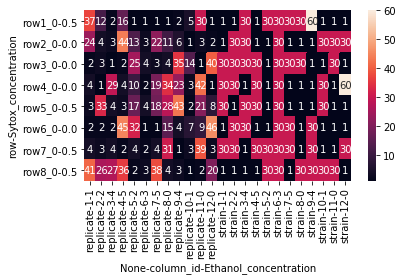

In [9]:
a = df.drop(columns=['measurement_type', "timepoint", 
                     "sample", "container", "recovery_media", 
                     "batch", "temperature", "experiment_id"]).drop_duplicates().sort_values(by=["column_id", "row"])
mymap = {'None':1, 'MediaControl':60, 'MG1655_WT':30}
a= a.applymap(lambda s: mymap.get(s) if s in mymap else s)
b = a.pivot_table(index=['row', 'Sytox_concentration'], columns=['column_id', 'Ethanol_concentration'])
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(b, annot=True)
plt.tight_layout()
#a